# Environment Comparison

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from analysis import Analysis2Fits
from experiment import Experiment
from utils import eval_position, ENV2_EVAL_BATCHES
from scipy.stats import norm
from gc import collect


data_path = "../data"
save_path = "../figs"

In [2]:
a2f = Analysis2Fits(data_path, '2fits')

### Losses

In [3]:
losses = a2f.get_pos_losses()

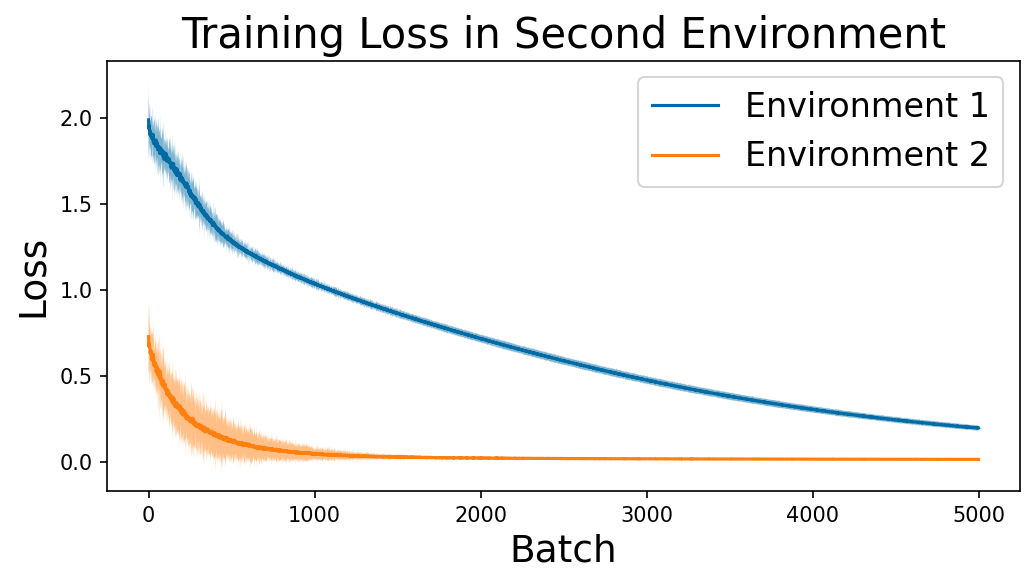

In [4]:
plt.figure(figsize=(7, 4), dpi=150)

i = 5000
for j in range(2):
    mean, std = losses.mean(1)[j, :i], losses.std(1)[j, :i] * 5
    plt.plot(mean, label=f'Environment {j+1}')
    plt.fill_between(range(i), mean + std, mean - std, alpha=0.5)

plt.legend(fontsize=16)
plt.xlabel('Batch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title("Training Loss in Second Environment", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'loss_env2.png'))
plt.show()

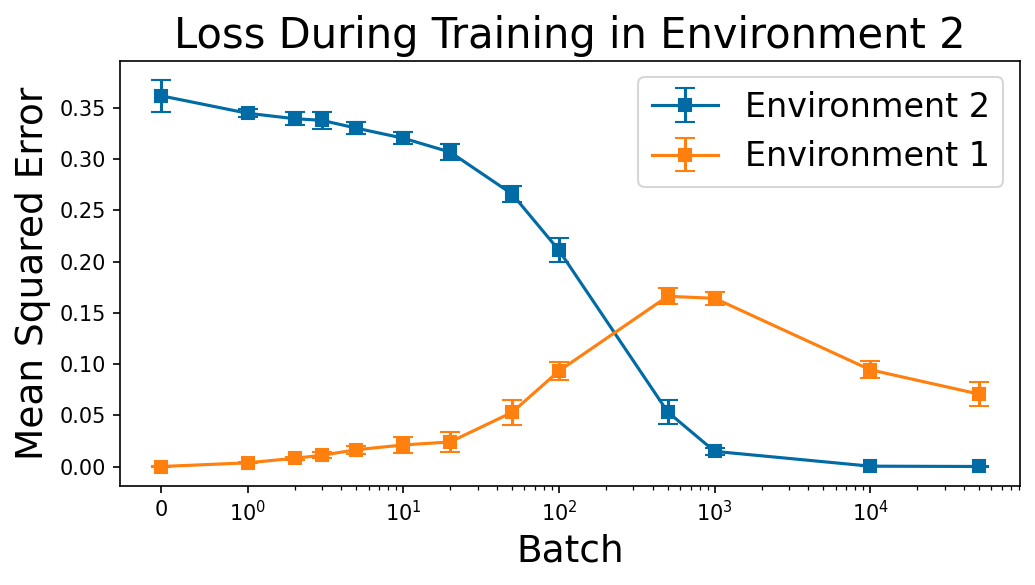

In [5]:
plt.figure(figsize=(7, 4), dpi=150)

cis = a2f.evals.std(0) * norm.ppf(0.995) / np.sqrt(a2f.evals.shape[0])
for mean, ci in zip(a2f.evals.mean(0), cis):
    plt.errorbar(ENV2_EVAL_BATCHES, mean, yerr=ci, capsize=5, fmt='s-')
plt.xscale('symlog', linthresh=1, subs=range(2, 10), linscale=0.5)

plt.legend(["Environment 2", "Environment 1"], fontsize=16)
plt.xlabel('Batch', fontsize=18)
plt.ylabel('Mean Squared Error', fontsize=18)
plt.title("Loss During Training in Environment 2", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'validation_env2.png'))
plt.show()

In [8]:
a2f.df2.loc[:, 1, :]

active      place
0 proportion     0.234375   0.210938
  coverage       1.000000   0.844731
  intersection  29.000000  26.000000
  union         32.000000  32.000000
  IoU            0.906250   0.812500
  turnover       0.064565   0.182857
  scales              NaN   0.417051
  sizes               NaN   0.070257
  remapping           NaN   0.292685
1 proportion     0.273438   0.234375
  coverage       1.000000   0.895631
  intersection  35.000000  30.000000
  union         37.000000  37.000000
  IoU            0.945946   0.810811
  turnover       0.038647   0.255404
  scales              NaN   0.382804
  sizes               NaN   0.080242
  remapping           NaN   0.407777
2 proportion     0.257812   0.179688
  coverage       1.000000   0.647956
  intersection  32.000000  22.000000
  union         35.000000  35.000000
  IoU            0.914286   0.628571
  turnover       0.060649   0.434389
  scales              NaN   0.491685
  sizes               NaN   0.047572
  remapping           NaN   0.315707
3 proportion     0.242188   0.203125
  coverage       1.000000   0.866062
  intersection  31.000000  26.000000
  union         34.000000  34.000000
  IoU            0.911765   0.764706
  turnover       0.061861   0.248259
  scales              NaN   0.430464
  sizes               NaN   0.065762
  remapping           NaN   0.332999
4 proportion     0.226562   0.179688
  coverage       1.000000   0.712706
  intersection  29.000000  23.000000
  union         33.000000  33.000000
  IoU            0.878788   0.696970
  turnover       0.085135   0.338797
  scales              NaN   0.439359
  sizes               NaN   0.057016
  remapping           NaN   0.402416

### Remapping

In [6]:
exp_names = ['2fits50b', '2fits500b', '2fits5000b', '2fits']
batches = [50, 500, 5000, 50000]

df = Analysis2Fits.get_retrain_remaps(data_path, exp_names)
df = df.rename(index={i: b for i, b in zip(exp_names, batches)})

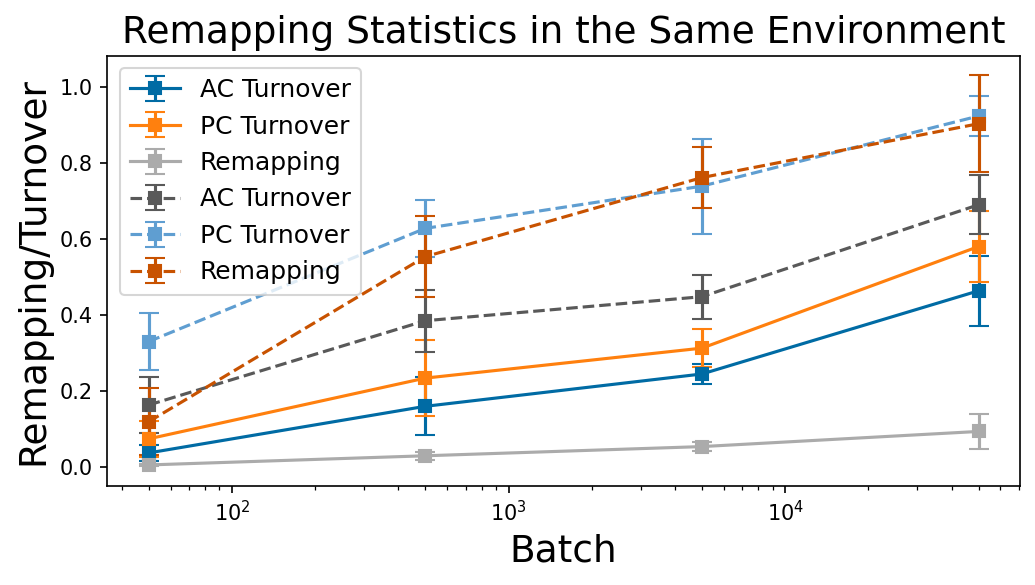

In [7]:
plt.figure(figsize=(7, 4), dpi=150)

group = df.groupby(level=(0, 2), sort=False)
means = group.mean().unstack(0).T.groupby(level=0)
stds = group.std().unstack(0).T
cis = stds * norm.ppf(0.995) / np.sqrt(df.index.get_level_values(1).unique().size)

fmts = {"1_1'": 's-', "2_2'": 's--'}
for (l, remap), (_, ci) in zip(means, cis.groupby(level=0)):
    remap = remap.droplevel(0).T.iterrows()
    ci = ci.droplevel(0).T.iterrows()
    for (stat, row), (_, s) in zip(remap, ci):
        plt.errorbar(batches, row, yerr=s, capsize=5, label=stat, fmt=fmts[l])
plt.xscale('log')

plt.legend(["AC Turnover", "PC Turnover", "Remapping"] * 2, fontsize=12)
plt.xlabel('Batch', fontsize=18)
plt.ylabel('Remapping/Turnover', fontsize=18)
plt.title("Remapping Statistics in the Same Environment", fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'remaps_env2.png'))
plt.show()